In [1]:
# Import the packages
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
# Declare some global inputs
test_names = ["PH_20230202_LovedBrandsDavao", "PH_20230202_LovedBrandsMisamis oriental", "PH_20230202_LovedBrands_ASA_547_Marikina", "PH_20230202_LovedBrandsIloilo"]
lb_pipeline_run_date = "2023-03-16"
asa_ids = ["10", "185", "547", "25"]
entity_id = "FP_PH"
lb_designated_tg = "Target Group 2" # Depending on whether or not there are conditions in the test, the Loved Brands can be in other target groups different from TG1
nlb_designated_tg = "Target Group 3" # Depending on whether or not there are conditions in the test, the non-Loved Brands can be in other target groups different from TG2
ela_var = "Variation4" # Elasticity variant in the test
num_bootstrap_samples = 1000 # Number of data points to have on the histogram
cl = 0.95
left_threshold = round((1 - cl) / 2, 4)
right_threshold = round((1 - (1 - cl) / 2), 4)

# Create a data frame combining the test name with the targeted ASA
df_test_asa = pd.DataFrame({"test_name": test_names, "asa_id_of_test": asa_ids})

In [3]:
# Instantiate the BQ client
client = bigquery.Client(project="dh-logistics-product-ops")
bqstorage_client = bigquery_storage.BigQueryReadClient()

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\google\auth\_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
# Query the test data and join the resulting data frame with df_test_asa
df_test_data = client.query(
    query=f"""
        SELECT * FROM `dh-logistics-product-ops.pricing.ab_test_individual_orders_cleaned_lb_rollout_tests`
        WHERE test_name IN ('{"', '".join(test_names)}')
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

df_test_data = pd.merge(left=df_test_data, right=df_test_asa, how="left", on="test_name")

Downloading: 100%|██████████| 1158847/1158847 [01:44<00:00, 11050.15rows/s]


In [5]:
# Query the Loved Brands based on the last pipeline run
df_lb_pipeline = client.query(
    query=f"""
        SELECT * FROM `dh-logistics-product-ops.pricing.final_vendor_list_all_data_loved_brands_scaled_code`
        WHERE TRUE
            AND DATE(update_timestamp) = DATE("{lb_pipeline_run_date}")
            AND asa_id IN ({', '.join(asa_ids)})
            AND entity_id = "{entity_id}"
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

Downloading: 100%|██████████| 5243/5243 [00:02<00:00, 2524.07rows/s]


In [6]:
# Create three data frames for simple LBs, full LBs and non-LBs
common_cols = [
    "region",
    "entity_id",
    "country_code",
    "asa_id",
    "master_asa_id",
    "asa_name",
    "asa_common_name",
    "vendor_code",
    "vertical_type",
    "vendor_rank_lm",
    "is_lb_lm",
]

simple_lbs = df_lb_pipeline[df_lb_pipeline["vendor_rank_lm"] == "Top 25%"][common_cols]
full_lbs = df_lb_pipeline[df_lb_pipeline["is_lb_lm"] == "Y"][common_cols]
non_lbs = df_lb_pipeline[df_lb_pipeline["is_lb_lm"] == "N"][common_cols]

In [7]:
# Display the number of vendors per ASA ID for each of the data frames created above
print("The number of simple Loved Brands per ASA...")
display(simple_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

print("\nThe number of full Loved Brands per ASA...")
display(full_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

print("\nThe number of non-Loved Brands per ASA...")
display(non_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

The number of simple Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_PH,10,N,89
1,FP_PH,10,Y,120
2,FP_PH,25,N,30
3,FP_PH,25,Y,54
4,FP_PH,185,N,29
5,FP_PH,185,Y,122
6,FP_PH,547,N,116
7,FP_PH,547,Y,84



The number of full Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_PH,10,Y,120
1,FP_PH,25,Y,54
2,FP_PH,185,Y,122
3,FP_PH,547,Y,84



The number of non-Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_PH,10,N,1382
1,FP_PH,25,N,584
2,FP_PH,185,N,919
3,FP_PH,547,N,1978


In [8]:
# Run the bootstrapping function sequentially
vendor_labels = ["simple_lbs", "full_lbs", "non_lbs"]
df_sim_results = []
sim_counter = 1
for i in test_names:
    for j in vendor_labels:
        # Filter the data based on the test
        df_sub_test = df_test_data[df_test_data["test_name"] == i]

        # Filter the simple LBs data frame to the right set of vendors based on the ASA ID that belong to the test
        relevant_simple_lbs = simple_lbs[simple_lbs["asa_id"] == int(df_sub_test["asa_id_of_test"].unique()[0])]
        
        # Further filter the data based on the vendor labels
        if j == "full_lbs":
            df_sub_test = df_sub_test[df_sub_test["target_group_bi"] == lb_designated_tg]
        elif j == "non_lbs":
            df_sub_test = df_sub_test[df_sub_test["target_group_bi"] == nlb_designated_tg]
        else:
            df_sub_test = df_sub_test[df_sub_test["vendor_id"].isin(relevant_simple_lbs["vendor_code"])]
        
        # Elasticity calculated by pct difference in no. of transactions / pct difference in average DF
        for k in range(1, num_bootstrap_samples + 1):
            print(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {i}, vendor_group_label: {j}, sample_num: {k}")
            df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
            df_var_sample = df_sub_test[df_sub_test["variant"] == ela_var].sample(frac=1, replace=True)

            num_orders_ctl = df_ctl_sample["platform_order_code"].nunique()
            num_orders_var = df_var_sample["platform_order_code"].nunique()

            avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
            avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var

            pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
            pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)

            elasticity = pct_diff_orders / pct_diff_avg_df

            output_dict = {
                "test_name": i,
                "vendor_group_label": j,
                "sample_num": k,
                "elasticity": elasticity,
                "pct_diff_orders": pct_diff_orders,
                "pct_diff_avg_df": pct_diff_avg_df,
            }

            df_sim_results.append(output_dict)
            
            # Increment the sim counter
            sim_counter += 1

df_sim_results = pd.DataFrame(df_sim_results)

Iteration 1. Sampling with the following parameters --> test_name: PH_20230202_LovedBrandsDavao, vendor_group_label: simple_lbs, sample_num: 1
Iteration 2. Sampling with the following parameters --> test_name: PH_20230202_LovedBrandsDavao, vendor_group_label: simple_lbs, sample_num: 2
Iteration 3. Sampling with the following parameters --> test_name: PH_20230202_LovedBrandsDavao, vendor_group_label: simple_lbs, sample_num: 3
Iteration 4. Sampling with the following parameters --> test_name: PH_20230202_LovedBrandsDavao, vendor_group_label: simple_lbs, sample_num: 4
Iteration 5. Sampling with the following parameters --> test_name: PH_20230202_LovedBrandsDavao, vendor_group_label: simple_lbs, sample_num: 5
Iteration 6. Sampling with the following parameters --> test_name: PH_20230202_LovedBrandsDavao, vendor_group_label: simple_lbs, sample_num: 6
Iteration 7. Sampling with the following parameters --> test_name: PH_20230202_LovedBrandsDavao, vendor_group_label: simple_lbs, sample_num: 7

In [9]:
# Calculate the mean elasticity of LBs, non-LBs, and simple LBs per test
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"elasticity": list_of_agg_functions, "pct_diff_orders": list_of_agg_functions, "pct_diff_avg_df": list_of_agg_functions}
df_stats = df_sim_results.groupby(["test_name", "vendor_group_label"])[["elasticity", "pct_diff_orders", "pct_diff_avg_df"]].agg(agg_func_selection).reset_index()
df_stats

test_name vendor_group_label elasticity  \
                                                                      mean   
0               PH_20230202_LovedBrandsDavao           full_lbs  -0.173759   
1               PH_20230202_LovedBrandsDavao            non_lbs  -0.097055   
2               PH_20230202_LovedBrandsDavao         simple_lbs   0.000004   
3              PH_20230202_LovedBrandsIloilo           full_lbs  -0.485432   
4              PH_20230202_LovedBrandsIloilo            non_lbs  -0.344927   
5              PH_20230202_LovedBrandsIloilo         simple_lbs  -0.283850   
6    PH_20230202_LovedBrandsMisamis oriental           full_lbs  -0.033101   
7    PH_20230202_LovedBrandsMisamis oriental            non_lbs  -0.348782   
8    PH_20230202_LovedBrandsMisamis oriental         simple_lbs  -0.289469   
9   PH_20230202_LovedBrands_ASA_547_Marikina           full_lbs  -0.623181   
10  PH_20230202_LovedBrands_ASA_547_Marikina            non_lbs  -0.791823   
11  PH_20230202_LovedBrands_ASA_547_Marikina         simple_lbs  -0.715500   

                                    pct_diff_orders                  \
   percentile_left percentile_right            mean percentile_left   
0        -0.266204        -0.066994       -0.012591       -0.021040   
1        -0.216926         0.063234       -0.007122       -0.017254   
2        -0.110656         0.133579       -0.000187       -0.006557   
3        -0.648347        -0.330955       -0.024162       -0.033820   
4        -0.475759        -0.209460       -0.021823       -0.032376   
5        -0.404666        -0.148349       -0.015998       -0.023945   
6        -0.190771         0.194221       -0.002916       -0.015403   
7        -0.446988        -0.242263       -0.023250       -0.032333   
8        -0.400611        -0.168075       -0.014710       -0.022334   
9        -0.685190        -0.563706       -0.080308       -0.090313   
10       -0.866797        -0.722252       -0.101374       -0.111049   
11       -0.804480        -0.641418       -0.080635       -0.090062   

                    pct_diff_avg_df                                   
   percentile_right            mean percentile_left percentile_right  
0         -0.004172        0.071549        0.058426         0.084911  
1          0.003780        0.069623        0.051869         0.085660  
2          0.005848        0.053133        0.042285         0.063703  
3         -0.013661        0.050010        0.034065         0.066601  
4         -0.011351        0.063031        0.046462         0.080245  
5         -0.007531        0.056206        0.041703         0.070081  
6          0.010179        0.067852        0.046726         0.086792  
7         -0.014490        0.066466        0.052899         0.081440  
8         -0.007683        0.050671        0.039531         0.063237  
9         -0.070124        0.129034        0.112393         0.145556  
10        -0.091669        0.128287        0.111110         0.144056  
11        -0.071363        0.112987        0.096958         0.129325

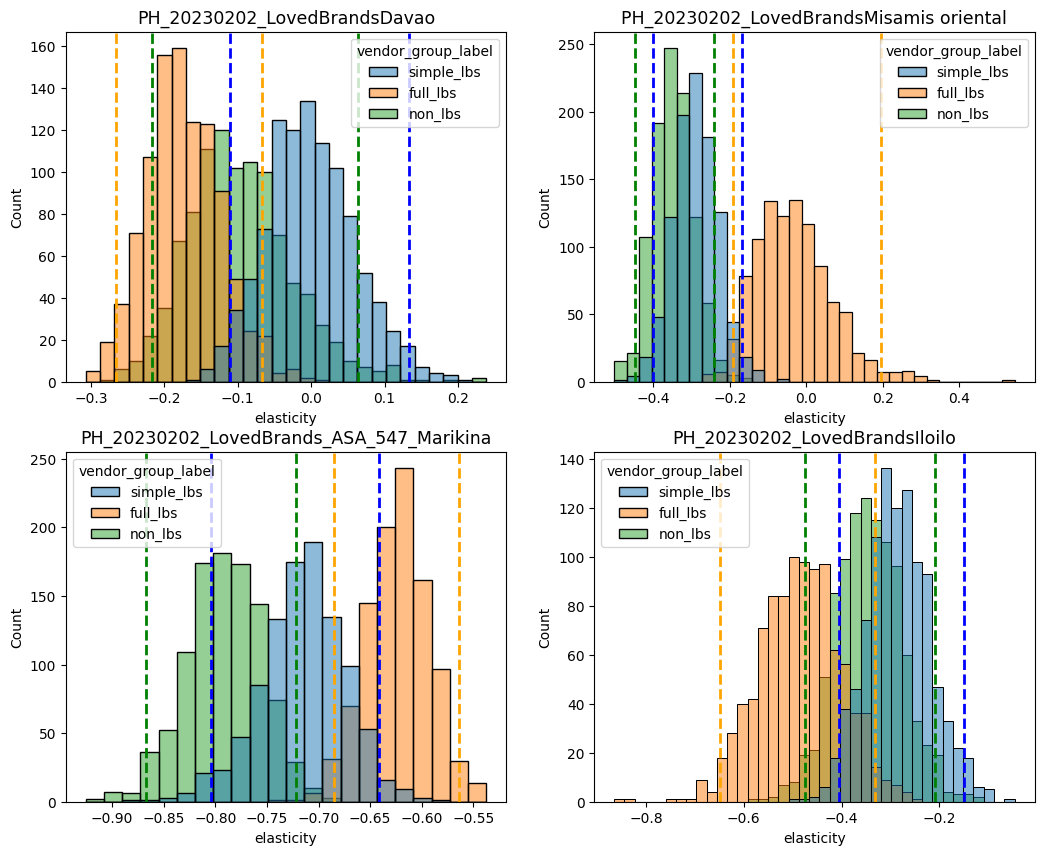

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12.5,10))
def plot_func(test_name, ax_x, ax_y):
    sns.histplot(data=df_sim_results[df_sim_results["test_name"] == test_name], x="elasticity", hue="vendor_group_label", ax=axes[ax_x, ax_y])
    percentile_left_flbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "full_lbs")]\
        ["elasticity"].reset_index(drop=True)["percentile_left"][0]
    percentile_left_nlbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "non_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_left"][0]
    percentile_left_slbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "simple_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_left"][0]

    percentile_right_flbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "full_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]
    percentile_right_nlbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "non_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]
    percentile_right_slbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "simple_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]

    axes[ax_x, ax_y].axvline(x = percentile_left_flbs, ymin=0, ymax=1, color = "orange", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_left_nlbs, ymin=0, ymax=1, color = "green", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_left_slbs, ymin=0, ymax=1, color = "blue", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_right_flbs, ymin=0, ymax=1, color = "orange", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_right_nlbs, ymin=0, ymax=1, color = "green", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_right_slbs, ymin=0, ymax=1, color = "blue", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].set_title(test_name, size = 12.5)

# Plot the graphs by looping over all tests
for idx, tst in enumerate(test_names):
    if idx == 0:
        ax_x = 0
        ax_y = 0
    elif idx == 1:
        ax_x = 0
        ax_y = 1
    elif idx == 2:
        ax_x = 1
        ax_y = 0
    if idx == 3:
        ax_x = 1
        ax_y = 1
    plot_func(test_name=tst, ax_x=ax_x, ax_y=ax_y)